# Customer Segmentation with K-Means Clustering

---
### Objective
Segment mall customers into meaningful behavioral groups based on their **annual income** and **spending score** to enable targeted marketing strategies.

### Workflow
1. Data Loading & Overview
2. Exploratory Data Analysis with Rich Visualizations
3. Feature Scaling & Preparation
4. Optimal K Selection (Elbow + Silhouette)
5. K-Means Clustering
6. Cluster Profiling & Business Insights Dashboard
7. Bonus: DBSCAN Comparison
8. Save Model for Deployment

### Dataset
[Mall Customer Segmentation – Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings
import joblib

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

# ── Style ──────────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor': '#0d1117',
    'axes.facecolor': '#161b22',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'xtick.color': '#8b949e',
    'ytick.color': '#8b949e',
    'text.color': '#c9d1d9',
    'grid.color': '#21262d',
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
})

CLUSTER_COLORS = ['#FF6B6B', '#FFD93D', '#6BCB77', '#4D96FF', '#C77DFF', '#FF8C00']
print('Libraries loaded!')

Libraries loaded!


## 1. Data Loading

In [2]:
# ── Load Data ────────────────────────────────────────────────
try:
    df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
except FileNotFoundError:
    np.random.seed(42)
    n = 200
    df = pd.DataFrame({
        'CustomerID': range(1, n+1),
        'Genre': np.random.choice(['Male', 'Female'], n),
        'Age': np.random.randint(18, 70, n),
        'Annual Income (k$)': np.random.randint(15, 137, n),
        'Spending Score (1-100)': np.random.randint(1, 100, n)
    })
    print('Using synthetic data')

# Standardize column names
df.columns = df.columns.str.strip()
if 'Gender' in df.columns:
    df.rename(columns={'Gender': 'Genre'}, inplace=True)

print(f'Shape: {df.shape}')
print(f'Columns: {list(df.columns)}')
df.head()

Using synthetic data
Shape: (200, 5)
Columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,49,68,69
1,2,Female,56,22,47
2,3,Male,66,41,94
3,4,Male,69,41,62
4,5,Male,49,112,69


In [3]:
# ── Overview Statistics ────────────────────────────────────────
print('\n' + '='*50)
print('DATASET SUMMARY')
print('='*50)
print(df.describe().to_string())
print(f'\n  Missing Values: {df.isnull().sum().sum()}')
print(f'  Gender Split: {df["Genre"].value_counts().to_dict()}')


DATASET SUMMARY
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   44.405000           75.635000               49.580000
std     57.879185   15.353816           35.410752               29.316049
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   32.750000           43.750000               23.750000
50%    100.500000   46.000000           74.000000               48.500000
75%    150.250000   56.000000          109.000000               74.250000
max    200.000000   69.000000          136.000000               99.000000

  Missing Values: 0
  Gender Split: {'Male': 100, 'Female': 100}


## 2. Exploratory Data Analysis

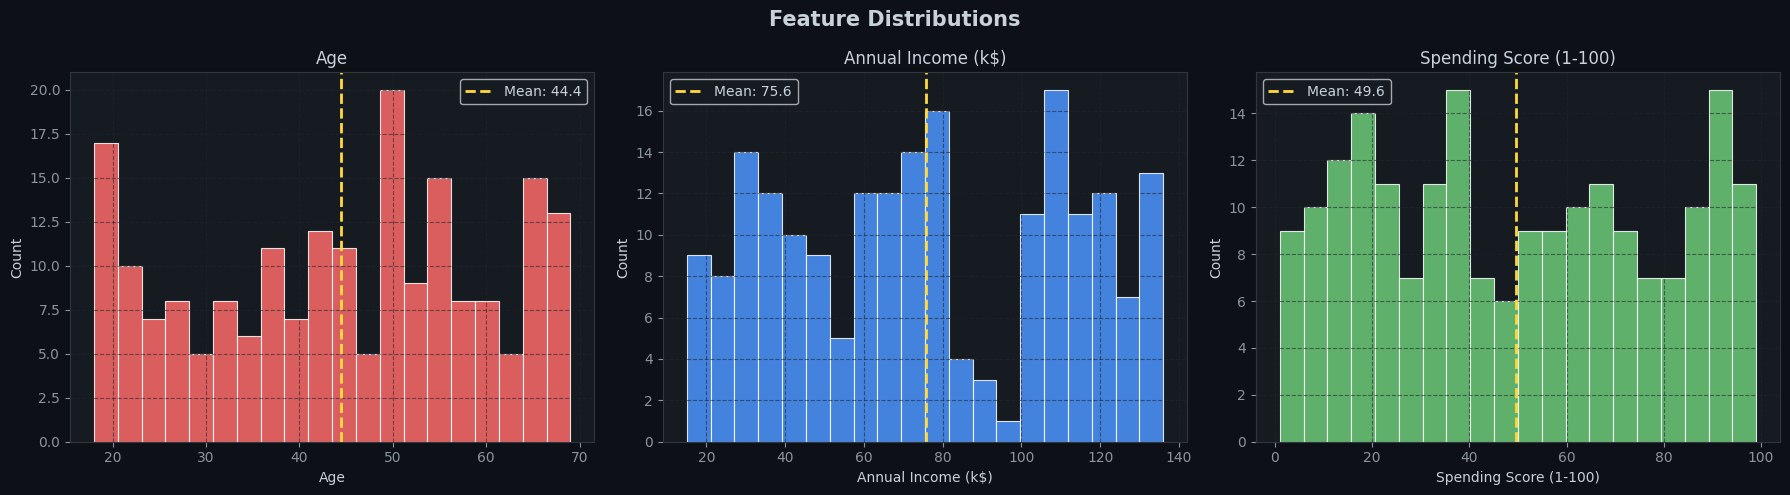

In [4]:
# ── Distribution Plots ────────────────────────────────────────
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Feature Distributions', fontsize=15, fontweight='bold')

for ax, col, color in zip(axes, num_cols, ['#FF6B6B', '#4D96FF', '#6BCB77']):
    ax.hist(df[col], bins=20, color=color, edgecolor='white', alpha=0.85, linewidth=0.8)
    ax.axvline(df[col].mean(), color='#FFD93D', linewidth=2, linestyle='--',
               label=f'Mean: {df[col].mean():.1f}')
    ax.set_title(col, fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('distributions.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

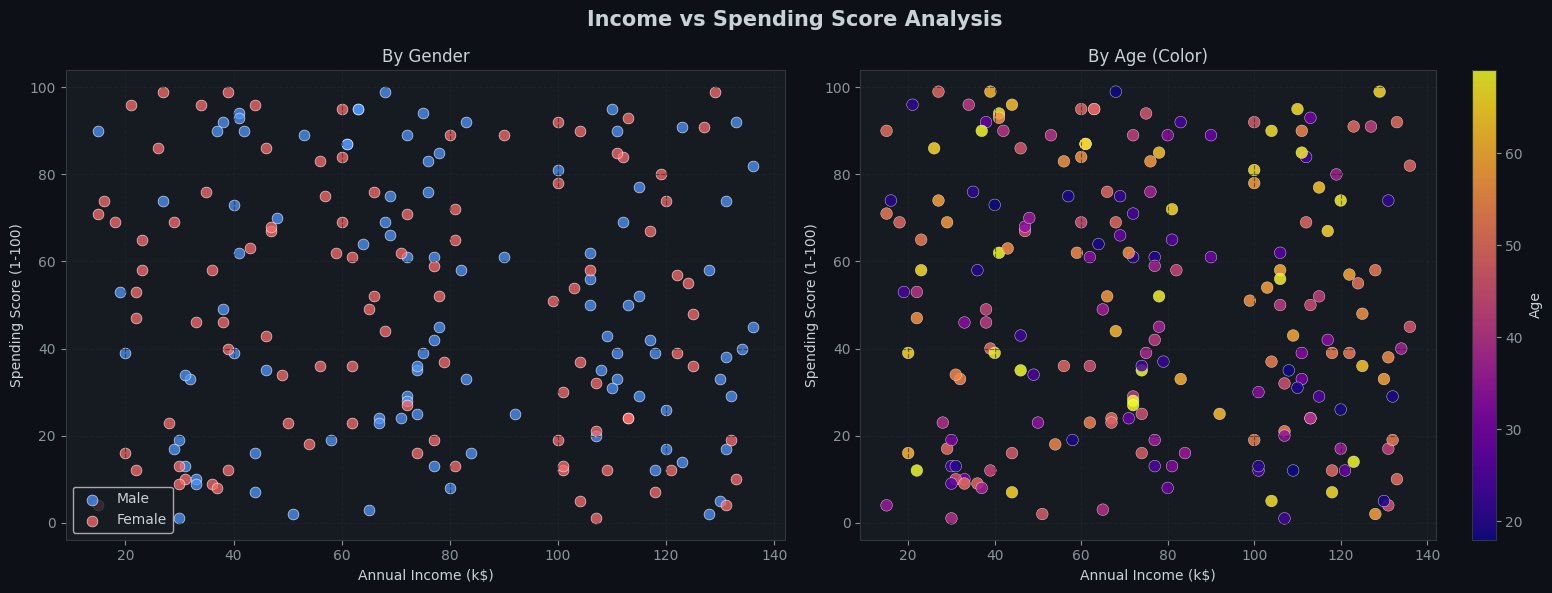

In [5]:
# ── Income vs Spending Scatter (Pre-Clustering) ────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Income vs Spending Score Analysis', fontsize=15, fontweight='bold')

# Scatter by gender
for genre, color in zip(['Male', 'Female'], ['#4D96FF', '#FF6B6B']):
    mask = df['Genre'] == genre
    axes[0].scatter(df.loc[mask, 'Annual Income (k$)'],
                    df.loc[mask, 'Spending Score (1-100)'],
                    c=color, label=genre, alpha=0.75, s=60, edgecolors='white', linewidth=0.5)
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score (1-100)')
axes[0].set_title('By Gender')
axes[0].legend()
axes[0].grid(True)

# Scatter colored by age
sc = axes[1].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
                     c=df['Age'], cmap='plasma', alpha=0.85, s=70, edgecolors='white', linewidth=0.3)
plt.colorbar(sc, ax=axes[1], label='Age')
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].set_title('By Age (Color)')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('income_spending_scatter.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

## 3. Feature Scaling

In [6]:
# ── Select Features & Scale ────────────────────────────────────
FEATURES_2D = ['Annual Income (k$)', 'Spending Score (1-100)']
FEATURES_3D = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

X_2d = df[FEATURES_2D].values
X_3d = df[FEATURES_3D].values

scaler_2d = StandardScaler()
scaler_3d = StandardScaler()

X_2d_sc = scaler_2d.fit_transform(X_2d)
X_3d_sc = scaler_3d.fit_transform(X_3d)

print('Features scaled using StandardScaler')
print(f' 2D features: {FEATURES_2D}')
print(f' 3D features: {FEATURES_3D}')

Features scaled using StandardScaler
 2D features: ['Annual Income (k$)', 'Spending Score (1-100)']
 3D features: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


## 4. Finding Optimal Number of Clusters

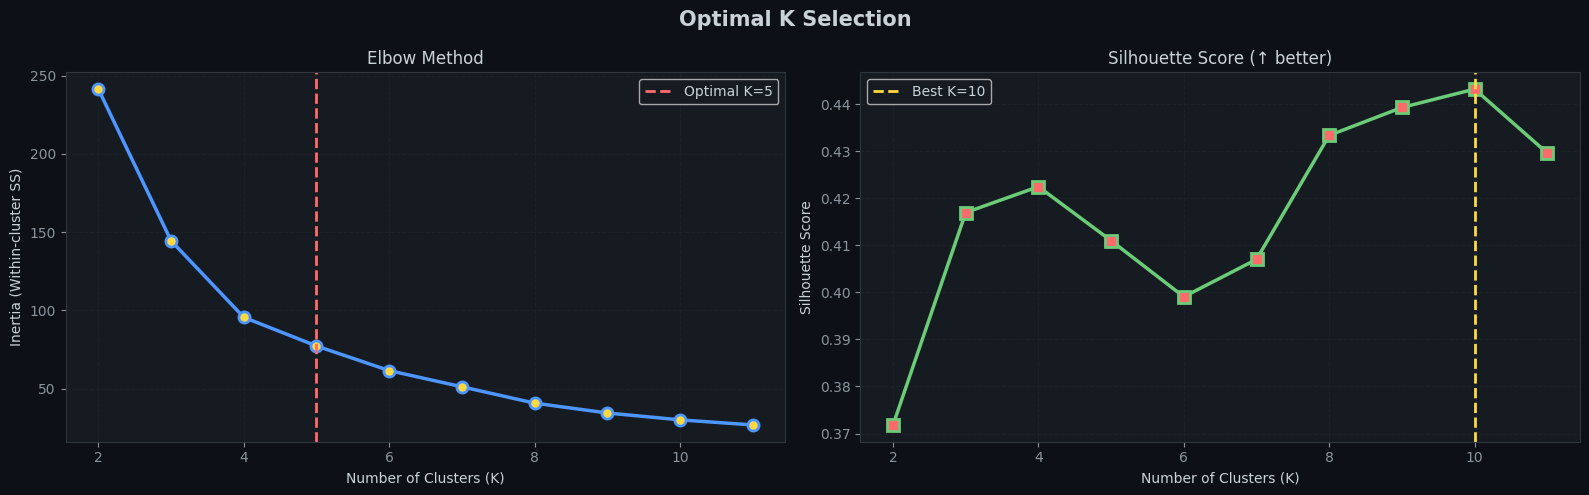


Selected K = 5 (industry standard for mall data)
   Silhouette Score at K=5: 0.4110


In [7]:
# ── Elbow Method + Silhouette Score ────────────────────────────
K_RANGE = range(2, 12)
inertias, silhouette_scores = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_2d_sc)
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_2d_sc, labels))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Optimal K Selection', fontsize=15, fontweight='bold')

# Elbow
axes[0].plot(list(K_RANGE), inertias, 'o-', color='#4D96FF', linewidth=2.5, markersize=8,
             markerfacecolor='#FFD93D', markeredgewidth=2)
axes[0].axvline(5, color='#FF6B6B', linestyle='--', linewidth=2, label='Optimal K=5')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-cluster SS)')
axes[0].set_title('Elbow Method')
axes[0].legend()
axes[0].grid(True)

# Silhouette
axes[1].plot(list(K_RANGE), silhouette_scores, 's-', color='#6BCB77', linewidth=2.5, markersize=8,
             markerfacecolor='#FF6B6B', markeredgewidth=2)
best_k = list(K_RANGE)[np.argmax(silhouette_scores)]
axes[1].axvline(best_k, color='#FFD93D', linestyle='--', linewidth=2, label=f'Best K={best_k}')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (↑ better)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('elbow_silhouette.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

OPTIMAL_K = 5
print(f'\nSelected K = {OPTIMAL_K} (industry standard for mall data)')
print(f'   Silhouette Score at K={OPTIMAL_K}: {silhouette_scores[OPTIMAL_K-2]:.4f}')

## 5. K-Means Clustering

In [8]:
# ── Fit KMeans ─────────────────────────────────────────────────
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=15, max_iter=500)
df['Cluster'] = kmeans.fit_predict(X_2d_sc)

# Cluster Names (business interpretation)
cluster_names = {
    0: 'High Income, Low Spend',
    1: 'Target Customers',
    2: 'Average Customers',
    3: 'Low Income, High Spend',
    4: 'Premium Customers',
}

# Auto-assign names based on centroid position
centers_orig = scaler_2d.inverse_transform(kmeans.cluster_centers_)
cluster_profiles = pd.DataFrame(centers_orig, columns=FEATURES_2D)
cluster_profiles['Cluster'] = range(OPTIMAL_K)
cluster_profiles['Count'] = df['Cluster'].value_counts().sort_index().values

# Smart naming
def name_cluster(row):
    inc, spen = row['Annual Income (k$)'], row['Spending Score (1-100)']
    if inc >= 70 and spen >= 60: return 'Premium Customers'
    elif inc >= 70 and spen < 40: return 'Careful Spenders'
    elif inc < 45 and spen >= 60: return 'Budget Enthusiasts'
    elif inc < 45 and spen < 40: return 'Low Engagement'
    else: return 'Average Customers'

cluster_profiles['Name'] = cluster_profiles.apply(name_cluster, axis=1)
name_map = dict(zip(cluster_profiles['Cluster'], cluster_profiles['Name']))
df['Cluster_Name'] = df['Cluster'].map(name_map)

print(f'\nK-Means clustering complete!')
print(f'   Inertia: {kmeans.inertia_:.2f}')
print(f'   Silhouette: {silhouette_score(X_2d_sc, df["Cluster"]):.4f}')
print('\nCluster Profiles:')
print(cluster_profiles[['Cluster', 'Name', 'Annual Income (k$)', 'Spending Score (1-100)', 'Count']].to_string(index=False))


K-Means clustering complete!
   Inertia: 77.30
   Silhouette: 0.4140

Cluster Profiles:
 Cluster              Name  Annual Income (k$)  Spending Score (1-100)  Count
       0 Premium Customers          110.444444               74.055556     36
       1  Careful Spenders          117.390244               24.243902     41
       2    Low Engagement           34.057143               24.057143     35
       3 Average Customers           50.125000               79.035714     56
       4  Careful Spenders           73.093750               30.875000     32


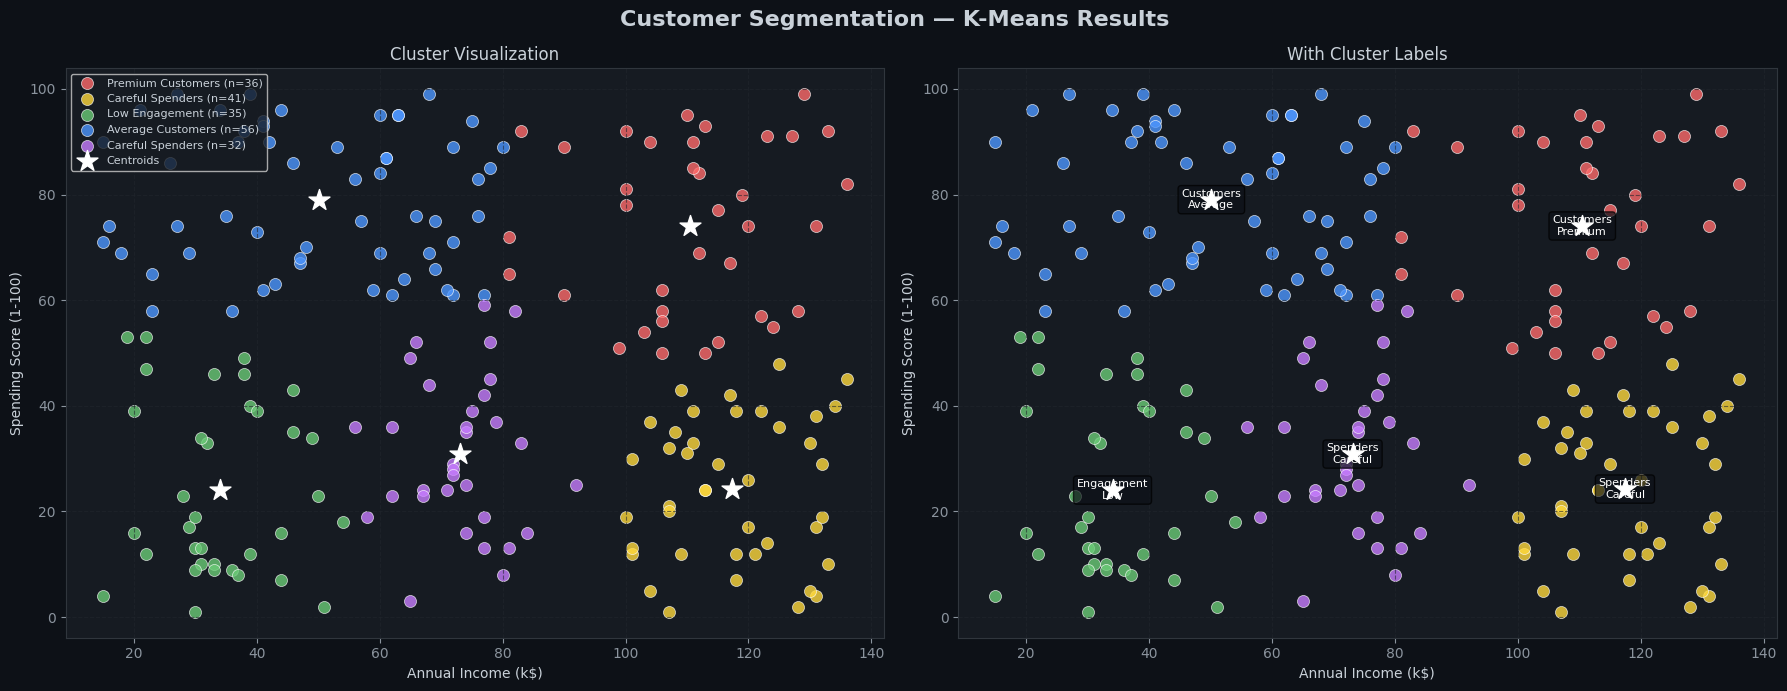

In [9]:
# ── Beautiful Cluster Visualization ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Customer Segmentation — K-Means Results', fontsize=16, fontweight='bold')

for ax_idx, ax in enumerate(axes):
    for cluster_id in range(OPTIMAL_K):
        mask = df['Cluster'] == cluster_id
        color = CLUSTER_COLORS[cluster_id]
        label = cluster_profiles.loc[cluster_profiles['Cluster']==cluster_id, 'Name'].values[0]
        ax.scatter(df.loc[mask, 'Annual Income (k$)'],
                   df.loc[mask, 'Spending Score (1-100)'],
                   c=color, label=f'{label} (n={mask.sum()})',
                   s=75, alpha=0.8, edgecolors='white', linewidth=0.5)
    
    # Centroids
    ax.scatter(centers_orig[:, 0], centers_orig[:, 1],
               c='white', s=250, marker='*', zorder=5, label='Centroids')
    ax.set_xlabel('Annual Income (k$)')
    ax.set_ylabel('Spending Score (1-100)')
    ax.grid(True)
    
    if ax_idx == 0:
        ax.set_title('Cluster Visualization')
        ax.legend(loc='upper left', fontsize=8)
    else:
        # Add cluster area labels
        for _, row in cluster_profiles.iterrows():
            ax.annotate(row['Name'].split()[-1] + '\n' + row['Name'].split()[0],
                        xy=(row['Annual Income (k$)'], row['Spending Score (1-100)']),
                        fontsize=8, ha='center', va='center',
                        color='white',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='#0d1117', alpha=0.7))
        ax.set_title('With Cluster Labels')

plt.tight_layout()
plt.savefig('cluster_visualization.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

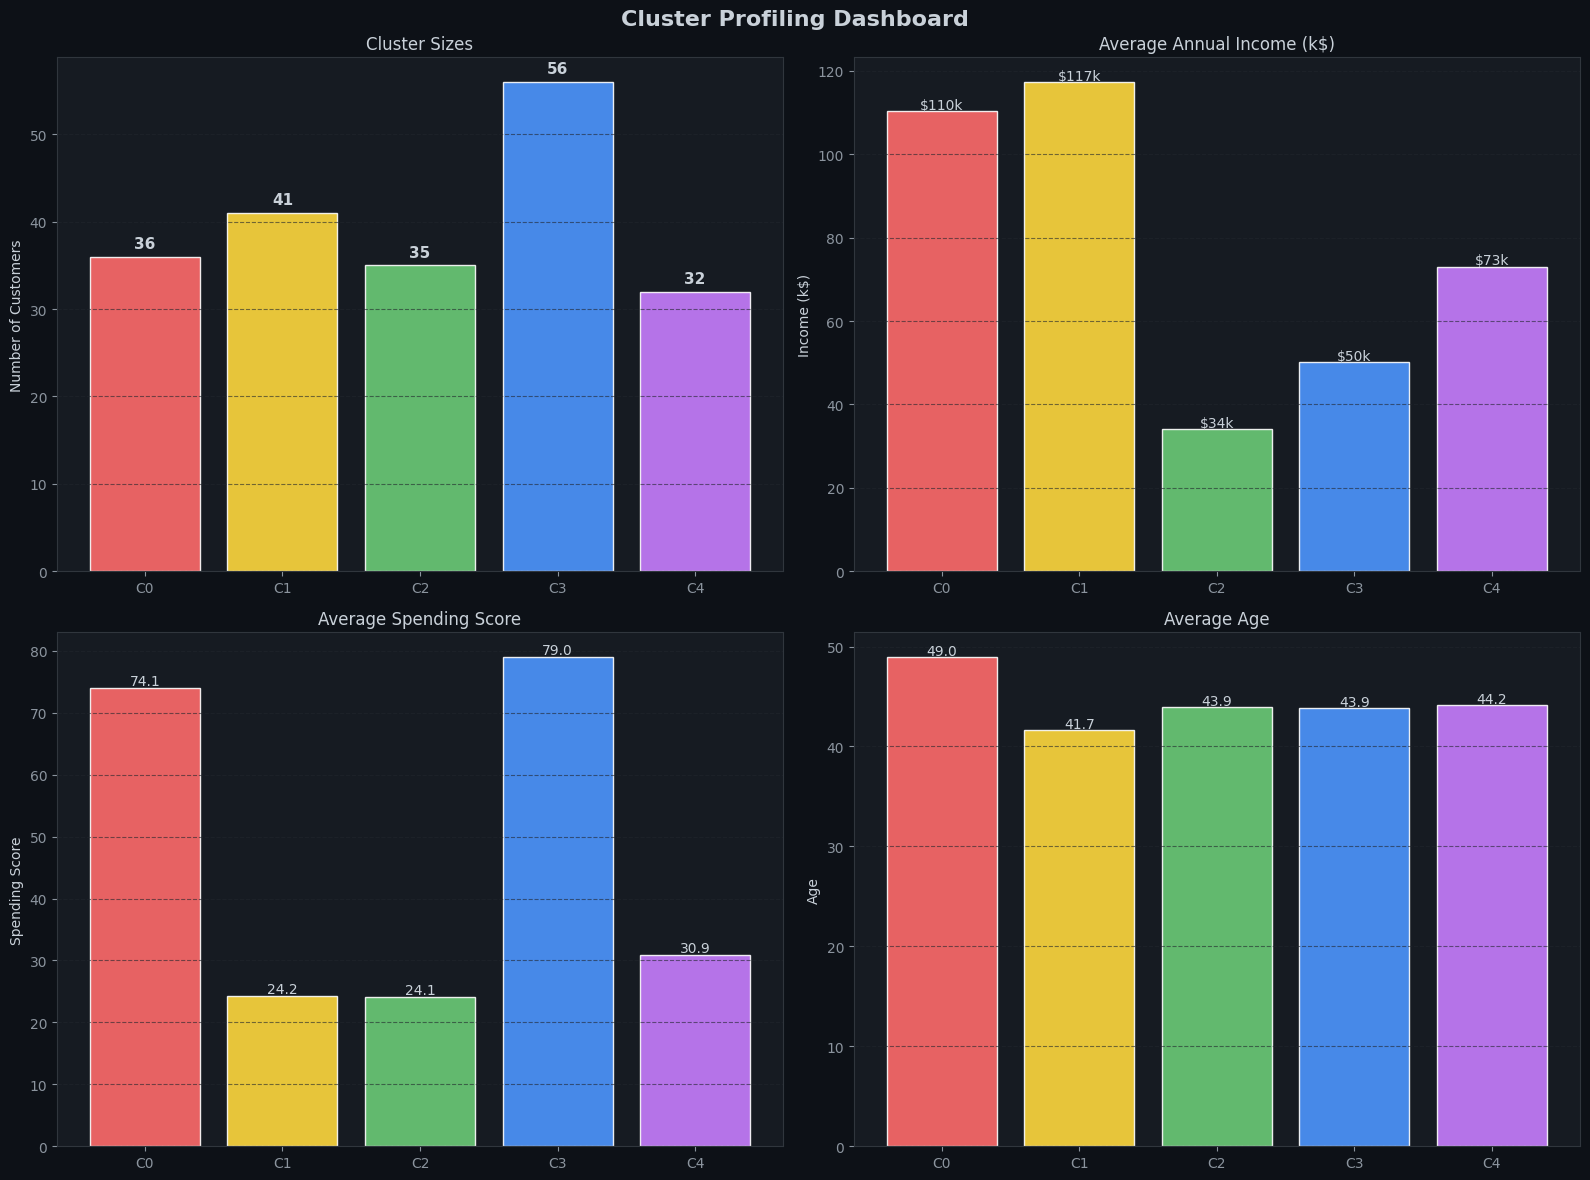

In [10]:
# ── Cluster Profiling Dashboard ────────────────────────────────
profile = df.groupby('Cluster').agg(
    Count=('Cluster', 'count'),
    Avg_Income=('Annual Income (k$)', 'mean'),
    Avg_Spending=('Spending Score (1-100)', 'mean'),
    Avg_Age=('Age', 'mean')
).reset_index()
profile['Name'] = profile['Cluster'].map(name_map)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cluster Profiling Dashboard', fontsize=16, fontweight='bold')

# Cluster sizes
axes[0,0].bar(range(OPTIMAL_K), profile['Count'], color=CLUSTER_COLORS[:OPTIMAL_K], 
              edgecolor='white', alpha=0.9)
axes[0,0].set_xticks(range(OPTIMAL_K))
axes[0,0].set_xticklabels([f'C{i}' for i in range(OPTIMAL_K)])
axes[0,0].set_title('Cluster Sizes')
axes[0,0].set_ylabel('Number of Customers')
for i, v in enumerate(profile['Count']):
    axes[0,0].text(i, v+1, str(v), ha='center', fontsize=11, fontweight='bold')
axes[0,0].grid(True, axis='y')

# Avg Income
axes[0,1].bar(range(OPTIMAL_K), profile['Avg_Income'], color=CLUSTER_COLORS[:OPTIMAL_K],
              edgecolor='white', alpha=0.9)
axes[0,1].set_xticks(range(OPTIMAL_K))
axes[0,1].set_xticklabels([f'C{i}' for i in range(OPTIMAL_K)])
axes[0,1].set_title('Average Annual Income (k$)')
axes[0,1].set_ylabel('Income (k$)')
for i, v in enumerate(profile['Avg_Income']):
    axes[0,1].text(i, v+0.5, f'${v:.0f}k', ha='center', fontsize=10)
axes[0,1].grid(True, axis='y')

# Avg Spending
axes[1,0].bar(range(OPTIMAL_K), profile['Avg_Spending'], color=CLUSTER_COLORS[:OPTIMAL_K],
              edgecolor='white', alpha=0.9)
axes[1,0].set_xticks(range(OPTIMAL_K))
axes[1,0].set_xticklabels([f'C{i}' for i in range(OPTIMAL_K)])
axes[1,0].set_title('Average Spending Score')
axes[1,0].set_ylabel('Spending Score')
for i, v in enumerate(profile['Avg_Spending']):
    axes[1,0].text(i, v+0.5, f'{v:.1f}', ha='center', fontsize=10)
axes[1,0].grid(True, axis='y')

# Avg Age
axes[1,1].bar(range(OPTIMAL_K), profile['Avg_Age'], color=CLUSTER_COLORS[:OPTIMAL_K],
              edgecolor='white', alpha=0.9)
axes[1,1].set_xticks(range(OPTIMAL_K))
axes[1,1].set_xticklabels([f'C{i}' for i in range(OPTIMAL_K)])
axes[1,1].set_title('Average Age')
axes[1,1].set_ylabel('Age')
for i, v in enumerate(profile['Avg_Age']):
    axes[1,1].text(i, v+0.2, f'{v:.1f}', ha='center', fontsize=10)
axes[1,1].grid(True, axis='y')

plt.tight_layout()
plt.savefig('cluster_profiles.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

BONUS: DBSCAN Clustering


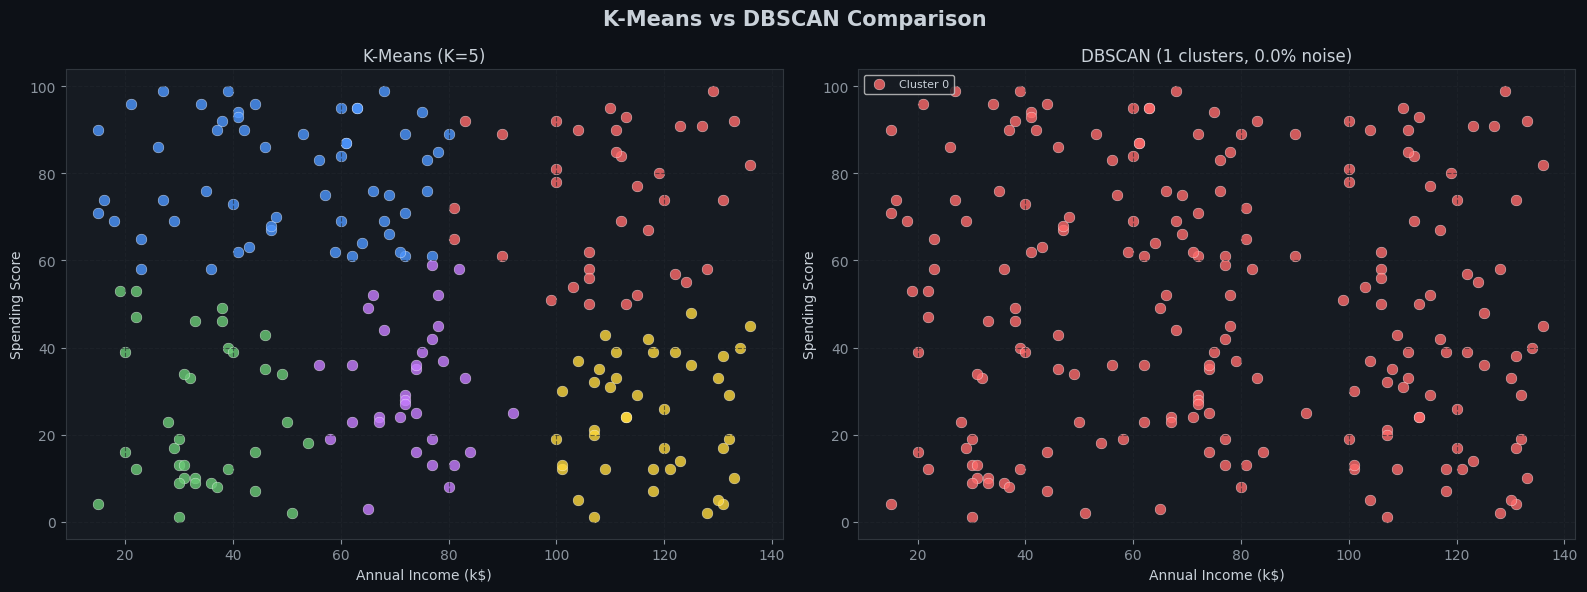

KMeans: 5 clusters | Silhouette=0.4140


In [11]:
# ── BONUS: DBSCAN Comparison ───────────────────────────────────
print('BONUS: DBSCAN Clustering')

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_2d_sc)
n_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
noise_pct = (dbscan_labels == -1).sum() / len(dbscan_labels) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('K-Means vs DBSCAN Comparison', fontsize=15, fontweight='bold')

# KMeans
for c in range(OPTIMAL_K):
    mask = df['Cluster'] == c
    axes[0].scatter(df.loc[mask, 'Annual Income (k$)'], df.loc[mask, 'Spending Score (1-100)'],
                    c=CLUSTER_COLORS[c], s=60, alpha=0.8, edgecolors='white', lw=0.3)
axes[0].set_title(f'K-Means (K=5)', fontsize=12)
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score')
axes[0].grid(True)

# DBSCAN
unique_labels = sorted(set(dbscan_labels))
for label in unique_labels:
    mask = dbscan_labels == label
    color = '#888888' if label == -1 else CLUSTER_COLORS[label % len(CLUSTER_COLORS)]
    lbl = 'Noise' if label == -1 else f'Cluster {label}'
    axes[1].scatter(df.loc[mask, 'Annual Income (k$)'], df.loc[mask, 'Spending Score (1-100)'],
                    c=color, s=60, alpha=0.8, edgecolors='white', lw=0.3, label=lbl)
axes[1].set_title(f'DBSCAN ({n_dbscan} clusters, {noise_pct:.1f}% noise)', fontsize=12)
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score')
axes[1].legend(fontsize=8)
axes[1].grid(True)

plt.tight_layout()
plt.savefig('kmeans_vs_dbscan.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

print(f'KMeans: {OPTIMAL_K} clusters | Silhouette={silhouette_score(X_2d_sc, df["Cluster"]):.4f}')
if n_dbscan > 1:
    valid_mask = dbscan_labels != -1
    print(f'DBSCAN: {n_dbscan} clusters | Noise={noise_pct:.1f}% | Silhouette={silhouette_score(X_2d_sc[valid_mask], dbscan_labels[valid_mask]):.4f}')

In [12]:
# ── Save Model ─────────────────────────────────────────────────
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler_2d, 'customer_scaler.pkl')
df.to_csv('clustered_customers.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv', index=False)

print('Model saved: kmeans_model.pkl')
print('Scaler saved: customer_scaler.pkl')
print('Results saved: clustered_customers.csv')

# Final Summary
print('\n' + '='*55)
print('CUSTOMER SEGMENTATION — FINAL RESULTS')
print('='*55)
for _, row in profile.iterrows():
    print(f'  Cluster {int(row["Cluster"])}: {row["Name"]}')
    print(f'    Count={int(row["Count"])} | Income=${row["Avg_Income"]:.0f}k | Spending={row["Avg_Spending"]:.0f}')
print('='*55)

Model saved: kmeans_model.pkl
Scaler saved: customer_scaler.pkl
Results saved: clustered_customers.csv

CUSTOMER SEGMENTATION — FINAL RESULTS
  Cluster 0: Premium Customers
    Count=36 | Income=$110k | Spending=74
  Cluster 1: Careful Spenders
    Count=41 | Income=$117k | Spending=24
  Cluster 2: Low Engagement
    Count=35 | Income=$34k | Spending=24
  Cluster 3: Average Customers
    Count=56 | Income=$50k | Spending=79
  Cluster 4: Careful Spenders
    Count=32 | Income=$73k | Spending=31


## Key Business Insights

| Segment | Strategy |
|---|---|
| Premium Customers | VIP loyalty programs, exclusive offers |
| Budget Enthusiasts | Value deals, promotional campaigns |
| Careful Spenders | Targeted luxury upselling |
| Average Customers | Mainstream marketing, cross-selling |
| Low Engagement | Re-engagement campaigns, discounts |